In [1]:
%pwd

'/Users/ryandevera/data-science/umn_environments/Deeplifting/deeplifting/notebooks'

In [2]:
%cd ../..

/Users/ryandevera/data-science/umn_environments/Deeplifting


In [3]:
%ls

README.md                      images/
__pycache__/                   jobs/
algorithm_compare_results/     models/
deeplifting/                   requirements.txt
deeplifting.png                results/
high-dimension-paper-results/  search_results/
high-dimension-search_results/ tasks.py


In [4]:
import glob as glob
import pandas as pd

In [5]:
file_directory = './high-dimension-paper-results/*/*'
files = glob.glob(file_directory)
files

['./high-dimension-paper-results/2023-09-12-17-09-chung_reynolds_100d/high-dimensional.parquet',
 './high-dimension-paper-results/2023-09-12-12-pygranso-layeb4_5d/high-dimensional.parquet',
 './high-dimension-paper-results/2023-09-12-12-pygranso-schwefel_30d/high-dimensional.parquet',
 './high-dimension-paper-results/2023-09-12-12-pygranso-rastrigin_30d/high-dimensional.parquet',
 './high-dimension-paper-results/2023-09-12-12-pygranso-ackley_1000d/high-dimensional.parquet',
 './high-dimension-paper-results/2023-09-13-13-09-griewank_5d/high-dimensional.parquet',
 './high-dimension-paper-results/2023-09-12-12-pygranso-chung_reynolds_100d/high-dimensional.parquet',
 './high-dimension-paper-results/2023-09-12-12-pygranso-rastrigin_5d/high-dimensional.parquet',
 './high-dimension-paper-results/2023-09-12-12-pygranso-levy_30d/high-dimensional.parquet',
 './high-dimension-paper-results/2023-09-12-12-pygranso-griewank_30d/high-dimensional.parquet',
 './high-dimension-paper-results/2023-09-12-1

In [6]:
# Load in the data
data = pd.read_parquet(files)
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x97,x98,x99,x100,f,algorithm,time,problem_name,hits,dimensions
0,-0.004824,-0.021410,-0.010362,-0.004445,0.007626,-0.014681,0.006305,-0.036057,-0.032823,0.011758,...,-0.008681,0.024704,-0.031818,-0.000593,0.003521,IPOPT,0.054880,chung_reynolds_100d,0,100
1,-0.000727,0.002041,0.026687,-0.001930,-0.004547,-0.006580,-0.003533,-0.001560,-0.000903,0.000276,...,0.006343,0.000663,0.026687,0.001064,0.000018,IPOPT,0.039149,chung_reynolds_100d,1,100
2,0.007098,0.034960,-0.005731,0.007123,0.008813,0.018782,0.032142,-0.013376,0.022062,0.025700,...,-0.015886,-0.017969,0.035540,-0.039953,0.004299,IPOPT,0.050758,chung_reynolds_100d,0,100
3,-0.005114,-0.020849,0.020943,-0.001101,-0.037765,-0.038005,0.036372,0.029062,0.040211,0.005950,...,-0.013417,0.013514,-0.005324,0.030115,0.003650,IPOPT,0.078572,chung_reynolds_100d,0,100
4,-0.029359,-0.004082,-0.027588,-0.018300,-0.016788,0.024034,-0.026030,0.006279,0.021073,0.005704,...,0.002410,0.009308,-0.010240,0.005555,0.001775,IPOPT,0.057365,chung_reynolds_100d,0,100


In [15]:
data['algorithm'].unique()

array(['IPOPT', 'Dual Annealing', 'Differential Evolution', 'SCIP',
       'PyGRANSO'], dtype=object)

In [19]:
aggregate_dict = {
    'f': ['count', 'min', 'mean', 'median', 'max'],
    'hits': ['mean'],
    'time': ['mean', 'median'],
}

# We want to group this data by
# problem name
# algorithm
# attributions are f, hits and time
results = data.groupby(['problem_name', 'algorithm', 'dimensions']).agg(aggregate_dict)

# Join the columns
results.columns = ['-'.join(column) for column in results.columns]
results = results.reset_index()
results

,problem_name,algorithm,dimensions,f-count,f-min,f-mean,f-median,f-max,hits-mean,time-mean,time-median
0,ackley_1000d,PyGRANSO,1000,1,19.962222,19.962222,19.962222,19.962222,0.0,203.335482,203.335482
1,ackley_100d,PyGRANSO,100,1,20.263312,20.263312,20.263312,20.263312,0.0,71.556902,71.556902
2,ackley_30d,PyGRANSO,30,1,19.849982,19.849982,19.849982,19.849982,0.0,3.441126,3.441126
3,ackley_3d,PyGRANSO,3,1,18.229625,18.229625,18.229625,18.229625,0.0,1.000219,1.000219
4,ackley_500d,PyGRANSO,500,1,19.952029,19.952029,19.952029,19.952029,0.0,109.903434,109.903434
...,...,...,...,...,...,...,...,...,...,...,...
113,schwefel_100d,PyGRANSO,100,1,13393.414411,13393.414411,13393.414411,13393.414411,0.0,83.628890,83.628890
114,schwefel_30d,PyGRANSO,30,1,5026.719828,5026.719828,5026.719828,5026.719828,0.0,1.308079,1.308079
115,schwefel_3d,PyGRANSO,3,1,532.983421,532.983421,532.983421,532.983421,0.0,0.179307,0.179307
116,schwefel_500d,PyGRANSO,500,1,71456.088454,71456.088454,71456.088454,71456.088454,0.0,463.586483,463.586483


In [24]:
# Look at the results for Ackley
time_df = results.loc[
    results['problem_name'].str.contains('chung_reynolds')
].pivot_table(index='dimensions', columns='algorithm', values='time-mean')

Text(0, 0.5, 'Time (Seconds)')

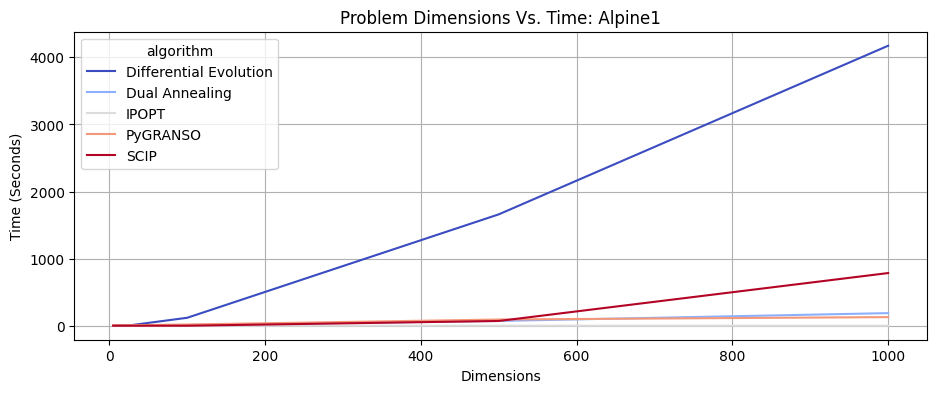

In [34]:
ax = time_df.plot(figsize=(11, 4), cmap='coolwarm')
ax.grid()
ax.set_title('Problem Dimensions Vs. Time: Alpine1')
ax.set_xlabel('Dimensions')
ax.set_ylabel('Time (Seconds)')